In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import innvestigate.utils as iutils
import innvestigate.utils.tests.networks.imagenet
import innvestigate.utils.visualizations as ivis
import sys

from keras.models import Model
from keras.layers import Input
from keras.layers.merge import Multiply
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution1D, AveragePooling1D

from Bio.SeqUtils import MeltingTemp as mt
#import RNA



Using TensorFlow backend.


In [2]:
def PREPROCESS(lines):
    data_n = len(lines) - 1
    SEQ = np.zeros((data_n, 34, 4), dtype=int)
    CA = np.zeros((data_n, 1), dtype=float)
    
    for l in range(1, data_n+1):
        data = lines[l].split()
        seq = data[0]
        for i in range(34):
            if seq[i] in "Aa":
                SEQ[l-1, i, 0] = 1
            elif seq[i] in "Cc":
                SEQ[l-1, i, 1] = 1
            elif seq[i] in "Gg":
                SEQ[l-1, i, 2] = 1
            elif seq[i] in "Tt":
                SEQ[l-1, i, 3] = 1
        CA[l-1,0] = float(data[1])

    return SEQ, CA


In [3]:
def Feature_Extraction(lines):
    lines = list(lines)
    data_n = len(lines)
    DATA_X = np.zeros((data_n,34,4), dtype=int)
    DATA_Y = np.zeros((data_n,), dtype=float)
    energy = np.zeros((data_n,), dtype=float)
    SEQ = []
    
    for l in range(data_n):
        data = lines[l].split()
        seq = data[0]
        SEQ.append(seq)
        for i in range(34):
            if seq[i] in "Aa":   DATA_X[l, i, 0] = 1
            elif seq[i] in "Cc": DATA_X[l, i, 1] = 1
            elif seq[i] in "Gg": DATA_X[l, i, 2] = 1
            elif seq[i] in "Tt": DATA_X[l, i, 3] = 1
        DATA_Y[l] = float(data[1])
        energy[l] = float(data[2])
    
    #Feature Extraction
    DATA_X_FE = np.zeros((data_n,689), dtype=float)
    for l in range(data_n):
        #position-independent nucleotides and dinucleotides (4 + 4^2 = 20)
        for i in range(4):
            DATA_X_FE[l,i] = sum(DATA_X[l,:,i])
        for i in range(4,20):
            DATA_X_FE[l,i] = Dinucleotide_FE(DATA_X[l], int((i-4)/4), int((i-4)%4))
            
        #position-dependent nucleotides and dinucleotides ( 4*34 + (4^2 * 33) = 664)
        for i in range(20, 156):
            DATA_X_FE[l,i] = DATA_X[l, int((i-20)/4), int((i-20)%4)]
        for i in range(156,684):
            DATA_X_FE[l,i] = Dinucleotide_FE(DATA_X[l, int((i-156)/16):int((i-156)/16+2), :], int(((i-156)%16)/4), int(((i-156)%16)%4))
            
        #Melting temperatiure (1)
        DATA_X_FE[l,684] = mt.Tm_NN(SEQ[l])
           
        #GC count (3)
        DATA_X_FE[l,685] = SEQ[l].count("G") + SEQ[l].count("g") + SEQ[l].count("C") + SEQ[l].count("c")
        if DATA_X_FE[l,685] <= 9:
            DATA_X_FE[l,686] = 1
            DATA_X_FE[l,687] = 0
        else:
            DATA_X_FE[l,686] = 0
            DATA_X_FE[l,687] = 1
            
        #Free energy
        #DATA_X_FE[l,688] = RNA.fold(SEQ[l])[1]
        DATA_X_FE[l,688] = energy[l]

    return DATA_X_FE, DATA_Y

def Dinucleotide_FE(X, a, b):
    num = 0
    for i in range(X.shape[0]-1):
        if X[i,a] == 1 and X[i+1,b] == 1:
            num += 1
    return num

In [4]:
print("Usage: python DeepCpf1.py input.txt output.txt")
print("input.txt must include 3 columns with single header row")
print("\t1st column: sequence index")
print("\t2nd column: 34bp target sequence")
print("\t3rd column: binary chromain information of the target sequence\n")

print("DeepCpf1 currently requires python=2.7.12, theano=0.7.0, keras=0.3.3")
print("DeepCpf1 available on GitHub requires pre-obtained binary chromatin information (DNase-seq narraow peak data from ENCODE)")
print("DeepCpf1 web tool, available at http://data.snu.ac.kr/DeepCpf1, provides entire pipeline including binary chromatin accessibility for 125 cell lines\n")

if len(sys.argv) < 3:
    sys.exit()

print("Building models")
Seq_deepCpf1_Input_SEQ = Input(shape=(34,4))
Seq_deepCpf1_C1 = Convolution1D(80, 5, activation='relu')(Seq_deepCpf1_Input_SEQ)
Seq_deepCpf1_P1 = AveragePooling1D(2)(Seq_deepCpf1_C1)
Seq_deepCpf1_F = Flatten()(Seq_deepCpf1_P1)
Seq_deepCpf1_DO1= Dropout(0.3)(Seq_deepCpf1_F)
Seq_deepCpf1_D1 = Dense(80, activation='relu')(Seq_deepCpf1_DO1)
Seq_deepCpf1_DO2= Dropout(0.3)(Seq_deepCpf1_D1)
Seq_deepCpf1_D2 = Dense(40, activation='relu')(Seq_deepCpf1_DO2)
Seq_deepCpf1_DO3= Dropout(0.3)(Seq_deepCpf1_D2)
Seq_deepCpf1_D3 = Dense(40, activation='relu')(Seq_deepCpf1_DO3)
Seq_deepCpf1_DO4= Dropout(0.3)(Seq_deepCpf1_D3)
Seq_deepCpf1_Output = Dense(1, activation='linear')(Seq_deepCpf1_DO4)
Seq_deepCpf1 = Model(inputs=[Seq_deepCpf1_Input_SEQ], outputs=[Seq_deepCpf1_Output])

DeepCpf1_Input_SEQ = Input(shape=(34,4))
DeepCpf1_C1 = Convolution1D(80, 5, activation='relu')(DeepCpf1_Input_SEQ)
DeepCpf1_P1 = AveragePooling1D(2)(DeepCpf1_C1)
DeepCpf1_F = Flatten()(DeepCpf1_P1)
DeepCpf1_DO1= Dropout(0.3)(DeepCpf1_F)
DeepCpf1_D1 = Dense(80, activation='relu')(DeepCpf1_DO1)
DeepCpf1_DO2= Dropout(0.3)(DeepCpf1_D1)
DeepCpf1_D2 = Dense(40, activation='relu')(DeepCpf1_DO2)
DeepCpf1_DO3= Dropout(0.3)(DeepCpf1_D2)
DeepCpf1_D3_SEQ = Dense(40, activation='relu')(DeepCpf1_DO3)

DeepCpf1_Input_CA = Input(shape=(1,))
DeepCpf1_D3_CA = Dense(40, activation='relu')(DeepCpf1_Input_CA)
DeepCpf1_M = Multiply()([DeepCpf1_D3_SEQ, DeepCpf1_D3_CA])

DeepCpf1_DO4= Dropout(0.3)(DeepCpf1_M)
DeepCpf1_Output = Dense(1, activation='linear')(DeepCpf1_DO4)
DeepCpf1 = Model(inputs=[DeepCpf1_Input_SEQ, DeepCpf1_Input_CA], outputs=[DeepCpf1_Output])

#print("Loading weights for the models")
Seq_deepCpf1.load_weights('weights/Seq_deepCpf1_weights.h5')
DeepCpf1.load_weights('weights/DeepCpf1_weights.h5')

print("Loading training data")
FILE = open("Figure1b/training.txt", "r")
data = FILE.readlines()
SEQ, IF = PREPROCESS(data)
FILE.close()

Usage: python DeepCpf1.py input.txt output.txt
input.txt must include 3 columns with single header row
	1st column: sequence index
	2nd column: 34bp target sequence
	3rd column: binary chromain information of the target sequence

DeepCpf1 currently requires python=2.7.12, theano=0.7.0, keras=0.3.3
DeepCpf1 available on GitHub requires pre-obtained binary chromatin information (DNase-seq narraow peak data from ENCODE)
DeepCpf1 web tool, available at http://data.snu.ac.kr/DeepCpf1, provides entire pipeline including binary chromatin accessibility for 125 cell lines

Building models


Loading training data


In [5]:

# Use scikit-learn to grid search the batch size and epochs
from keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf


# custom metric
def spear_corr(y_true, y_pred):
    tensor = tf.shape(y_pred)
    samples = tf.gather(tensor, 1)

    predictions_rank = tf.nn.top_k(y_pred, k=samples, sorted=True, name='prediction_rank').indices
    real_rank = tf.nn.top_k(y_true, k=samples, sorted=True, name='real_rank').indices
    rank_diffs = predictions_rank - real_rank
    rank_diffs_squared_sum = tf.reduce_sum(rank_diffs * rank_diffs)
    six = tf.constant(6)
    one = tf.constant(1.0)
    numerator = tf.cast(six * rank_diffs_squared_sum, dtype=tf.float32)
    divider = tf.cast(samples * samples * samples - samples, dtype=tf.float32)
    spearman_batch = one - numerator / divider
    return spearman_batch


# Function to create model, required for KerasClassifier
def create_model():
    # create model
    Seq_deepCpf1_Input_SEQ = Input(shape=(34,4))
    Seq_deepCpf1_C1 = Convolution1D(80, 5, activation='relu')(Seq_deepCpf1_Input_SEQ)
    Seq_deepCpf1_P1 = AveragePooling1D(2)(Seq_deepCpf1_C1)
    Seq_deepCpf1_F = Flatten()(Seq_deepCpf1_P1)
    Seq_deepCpf1_DO1= Dropout(0.3)(Seq_deepCpf1_F)
    Seq_deepCpf1_D1 = Dense(80, activation='relu')(Seq_deepCpf1_DO1)
    Seq_deepCpf1_DO2= Dropout(0.3)(Seq_deepCpf1_D1)
    Seq_deepCpf1_D2 = Dense(40, activation='relu')(Seq_deepCpf1_DO2)
    Seq_deepCpf1_DO3= Dropout(0.3)(Seq_deepCpf1_D2)
    Seq_deepCpf1_D3 = Dense(40, activation='relu')(Seq_deepCpf1_DO3)
    Seq_deepCpf1_DO4= Dropout(0.3)(Seq_deepCpf1_D3)
    Seq_deepCpf1_Output = Dense(1, activation='linear')(Seq_deepCpf1_DO4)
    Seq_deepCpf1 = Model(inputs=[Seq_deepCpf1_Input_SEQ], outputs=[Seq_deepCpf1_Output])
    Seq_deepCpf1.compile(optimizer='adam', loss='mean_squared_error', metrics=['acc'])
    return Seq_deepCpf1

In [6]:
from scipy.stats import spearmanr


def train_and_evaluate_model(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train, batch_size=50, verbose=0)
    model_score = model.predict([x_test], batch_size=50, verbose=0)
    rho, p = spearmanr(model_score, y_test)
    return rho

In [7]:
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import linear_model
import random

#X = SEQ
#Y = IF

# read feature extraction lines
FILE = open("Figure1b/training_energy.txt", "r")
lines = FILE.readlines()
FILE.close()

random.shuffle(lines)
#convert to numpy array
lines = np.array(lines)

IDX = [500, 1000, 2000, 4000, 8000, 13500, 15000]
#IDX = [10, 20]
n_folds = 10

lr_matrix = []
rr_matrix = []
rt_matrix = []
Seq_deepCpf1_matrix = []

for idx in IDX:
    print("Training Size: ", idx, " Sequences")
    X = SEQ[:idx]
    Y = IF[:idx]
    
    # 10-fold cross validation
    # define 10-fold cross validation test harness
    kFold = KFold(n_splits=n_folds, shuffle=True)
    
    lr_cvScores = []
    rr_cvScores = []
    rt_cvScores = [] 
    seq_cvScores = []
    
    for i, (train, test) in enumerate(kFold.split(X, Y)):
        print("Running Fold", i+1, "/", n_folds)
        #Clearing the model
        #model = None
        
        #do regression
        TRAIN_FEAT_X, TRAIN_FEAT_Y = Feature_Extraction(lines[train])
        VAL_FEAT_X, VAL_FEAT_Y = Feature_Extraction(lines[test])
        
        #Lasso Regression
        model = linear_model.Lasso()
        model.fit(TRAIN_FEAT_X, TRAIN_FEAT_Y)
        val_result = spearmanr(VAL_FEAT_Y, model.predict(VAL_FEAT_X))[0]
        lr_cvScores.append(val_result)
        
        #Ridge Regression
        model = linear_model.Ridge()
        model.fit(TRAIN_FEAT_X, TRAIN_FEAT_Y)
        val_result = spearmanr(VAL_FEAT_Y, model.predict(VAL_FEAT_X))[0]
        rr_cvScores.append(val_result)
        
        #Regression Tree
        model = GradientBoostingRegressor()
        # Training
        model.fit(TRAIN_FEAT_X, TRAIN_FEAT_Y) 
        # Validation
        val_result = spearmanr(VAL_FEAT_Y, model.predict(VAL_FEAT_X))[0]
        rt_cvScores.append(val_result)
        
        
        #do NN
        # create model
        model = create_model()
        # evaluate the model
        val_result = train_and_evaluate_model(model, X[train], Y[train], X[test], Y[test])
        seq_cvScores.append(val_result)
        
    #print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
    lr_matrix.append(lr_cvScores)
    rr_matrix.append(rr_cvScores)
    rt_matrix.append(rt_cvScores)
    Seq_deepCpf1_matrix.append(seq_cvScores)


Training Size:  500  Sequences
Running Fold 1 / 10


Running Fold 2 / 10


Running Fold 3 / 10


Running Fold 4 / 10


Running Fold 5 / 10


Running Fold 6 / 10


Running Fold 7 / 10


Running Fold 8 / 10


Running Fold 9 / 10


Running Fold 10 / 10


Training Size:  1000  Sequences
Running Fold 1 / 10


Running Fold 2 / 10


Running Fold 3 / 10


Running Fold 4 / 10


Running Fold 5 / 10


Running Fold 6 / 10


Running Fold 7 / 10


Running Fold 8 / 10


Running Fold 9 / 10


Running Fold 10 / 10


Training Size:  2000  Sequences
Running Fold 1 / 10


Running Fold 2 / 10


Running Fold 3 / 10


Running Fold 4 / 10


Running Fold 5 / 10


Running Fold 6 / 10


Running Fold 7 / 10


Running Fold 8 / 10


Running Fold 9 / 10


Running Fold 10 / 10


Training Size:  4000  Sequences
Running Fold 1 / 10


Running Fold 2 / 10


Running Fold 3 / 10


Running Fold 4 / 10


Running Fold 5 / 10


Running Fold 6 / 10


Running Fold 7 / 10


Running Fold 8 / 10


Running Fold 9 / 10


Running Fold 10 / 10


Training Size:  8000  Sequences
Running Fold 1 / 10


Running Fold 2 / 10


Running Fold 3 / 10


Running Fold 4 / 10


Running Fold 5 / 10


Running Fold 6 / 10


Running Fold 7 / 10


Running Fold 8 / 10


Running Fold 9 / 10


Running Fold 10 / 10


Training Size:  13500  Sequences
Running Fold 1 / 10


Running Fold 2 / 10


Running Fold 3 / 10


Running Fold 4 / 10


Running Fold 5 / 10


Running Fold 6 / 10


Running Fold 7 / 10


Running Fold 8 / 10


Running Fold 9 / 10


Running Fold 10 / 10


Training Size:  15000  Sequences
Running Fold 1 / 10


Running Fold 2 / 10


Running Fold 3 / 10


Running Fold 4 / 10


Running Fold 5 / 10


Running Fold 6 / 10


Running Fold 7 / 10


Running Fold 8 / 10


Running Fold 9 / 10


Running Fold 10 / 10


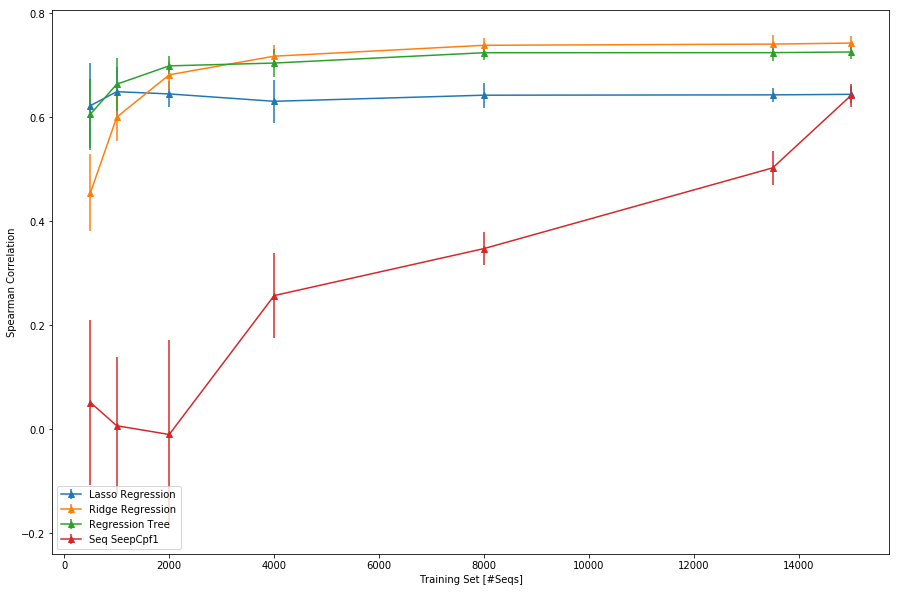

In [10]:
plt.rcParams["figure.figsize"] = (15, 10)

plt.errorbar(IDX, np.mean(lr_matrix, axis=1), yerr=np.std(lr_matrix, axis=1), marker='^', label="Lasso Regression")
plt.errorbar(IDX, np.mean(rr_matrix, axis=1), yerr=np.std(rr_matrix, axis=1), marker='^', label="Ridge Regression")
plt.errorbar(IDX, np.mean(rt_matrix, axis=1), yerr=np.std(rt_matrix, axis=1), marker='^', label="Regression Tree")
plt.errorbar(IDX, np.mean(Seq_deepCpf1_matrix, axis=1), yerr=np.std(Seq_deepCpf1_matrix, axis=1), marker='^', label="Seq SeepCpf1")

plt.ylabel("Spearman Correlation")
plt.xlabel("Training Set [#Seqs]")
plt.legend()

plt.show()



-5.5


In [ ]:

energy = []
with open('Figure1b/energy.txt', 'r') as file:
    lines = file.readlines()
    for row in lines:
        energy.append(float(row))

# read feature extraction lines
FILE = open("Figure1b/training.txt", "r")
lines = FILE.readlines()[1:]
FILE.close()
for i in range(len(lines)):
    lines[i] = lines[i].replace("\n", "\t"+str(energy[i])+"\n")
#convert to numpy array
lines = np.array(lines)


FILE = open("Figure1b/training_energy.txt", "w")
FILE.write("".join(lines))
FILE.close()